# run2 : ref no fold (3 classes)

* img reduce from  3x352x352 to 3x88x88
* no folding
* 3 classes 
* model = UNetLarge 

In [1]:
import sys,os
#apped depend on which machine 
paths = ['/data/solai/aiArmory/pytorch/', '/home/vlad/max78/aiArmory/pytorch/']
for path in paths:
    if os.path.exists(path):
        sys.path.append(path)
from armoInclude import *
from armoTrain import basicModel

## conf

In [2]:
# myPC
DATASET_PATH = '/data/tinyai/maxCNN/ai8x-training/data/CamVid'
MODEL_PATH = './unet_model_large_x88_c3_e50_F1.pt'  
EPOCHS_TO_RUN = 50
REDO = False

# ## runServer
# DATASET_PATH = '/home/vlad/Data/CamVid'
# MODEL_PATH = '/tmp/unet_model_large_x88_c3_e50_F1.pt'  
# REDO = True
# EPOCHS_TO_RUN = 50


In [3]:
IMAGE_SIZE = (88, 88)  
BATCH_SIZE = 8

## Model - basic reference model with no fold
NUM_CLASS   =   4   ## class+1 for none
NUM_CHANN   =   3
FOLD_RATIO  =   1



In [4]:
runDevice = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #<! The 1st CUDA device
print(f'runDevice: {runDevice}')

runDevice: cpu


## Layers

In [5]:
class UNetLarge(nn.Module):
    """
    Large size UNet model using PyTorch.

    num_classes 

        number of output classes the model is designed to predict.

    num_channels

        corresponds to the number of features or color channels in the input images (e.g., 3 for RGB images).

    fold_ratio
            The additional channels created by a higher fold_ratio can provide a richer and more detailed feature 
            representation, which may improve the model's ability to capture complex patterns and details in the 
            data, potentially enhancing accuracy. However, this comes at the cost of increased computational 
            complexity and memory usage

    """
    def __init__(self, num_classes, num_channels, fold_ratio ,bias=True):
        super(UNetLarge, self).__init__()
        self.fold_ratio = fold_ratio
        self.num_classes = num_classes
        self.num_final_channels = num_classes * fold_ratio * fold_ratio

        self.prep0 = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=1, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.prep1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.prep2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )

        self.enc1 = nn.Sequential(
            nn.Conv2d(32, 8, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 28, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm2d(28),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(28, 56, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm2d(56),
            nn.ReLU(inplace=True)
        )

        self.bneck = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(56, 112, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm2d(112),
            nn.ReLU(inplace=True)
        )

        self.upconv3 = nn.ConvTranspose2d(112, 56, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3 = nn.Sequential(
            nn.Conv2d(112, 56, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm2d(56),
            nn.ReLU(inplace=True)
        )

        self.upconv2 = nn.ConvTranspose2d(56, 28, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2 = nn.Sequential(
            nn.Conv2d(56, 28, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm2d(28),
            nn.ReLU(inplace=True)
        )

        self.upconv1 = nn.ConvTranspose2d(28, 8, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1 = nn.Sequential(
            nn.Conv2d(16, 48, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )

        self.dec0 = nn.Sequential(
            nn.Conv2d(48, 64, kernel_size=3, stride=1, padding=1, bias=bias),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.conv_p1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv_p2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv_p3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(64)
        )

        self.conv = nn.Sequential(
            nn.Conv2d(64, self.num_final_channels, kernel_size=1, stride=1, padding=0, bias=bias),
            nn.BatchNorm2d(self.num_final_channels)
        )

    def forward(self, x):
        x = self.prep0(x)
        x = self.prep1(x)
        x = self.prep2(x)

        enc1 = self.enc1(x)                   
        enc2 = self.enc2(enc1)                
        enc3 = self.enc3(enc2)                

        bottleneck = self.bneck(enc3)         

        dec3 = self.upconv3(bottleneck)       
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.dec3(dec3)                
        dec2 = self.upconv2(dec3)             
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.dec2(dec2)                
        dec1 = self.upconv1(dec2)             
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.dec1(dec1)                
        dec0 = self.dec0(dec1)                

        dec0 = self.conv_p1(dec0)
        dec0 = self.conv_p2(dec0)
        dec0 = self.conv_p3(dec0)
        dec0 = self.conv(dec0)                

        return dec0

## data


In [6]:
filter_label = [0,5,21,17] # car sky road

In [7]:
class CamVidDataset(Dataset):
    def __init__(self, image_dir, label_dir, image_transform=None, label_transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_transform = image_transform
        self.label_transform = label_transform
        self.image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
        self.label_paths = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir)])
        
        # Load class dictionary
        class_dict_path = os.path.join(DATASET_PATH, 'class_dict.csv')
        class_dict = pd.read_csv(class_dict_path)
        self.colormap = np.zeros((256**3,), dtype=int)

        if filter_label:
            print(f"...will filter classes")
            class_dict_filter = class_dict.filter(filter_label, axis=0)
        else:
            class_dict_filter = class_dict
        
        for i, row in class_dict_filter.iterrows():
            r, g, b = row['r'], row['g'], row['b']
            self.colormap[r * 256**2 + g * 256 + b] = i

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        label = Image.open(self.label_paths[idx]).convert('RGB')

        if self.image_transform:
            image = self.image_transform(image)
        if self.label_transform:
            label = self.label_transform(label)
        
        label = self.encode_segmap(np.array(label))  # Convert label to numpy array before encoding

        if filter_label:
            mapping = {old_value: new_index for new_index, old_value in enumerate(filter_label)}
            ## nromilize label by mapping
            label = np.vectorize(mapping.get)(label)

        return image, torch.from_numpy(label).long()

    def encode_segmap(self, mask):
        mask = mask.astype(int)
        index = mask[:, :, 0] * 256**2 + mask[:, :, 1] * 256 + mask[:, :, 2]
        return self.colormap[index]

# Step 4: Data Transformation and DataLoader
image_transform = TorchVisionTrns.Compose([
    TorchVisionTrns.Resize(IMAGE_SIZE),
    TorchVisionTrns.ToTensor()
])

label_transform = TorchVisionTrns.Compose([
    TorchVisionTrns.Resize(IMAGE_SIZE)
])

train_dataset = CamVidDataset(
    image_dir=os.path.join(DATASET_PATH, 'train'),
    label_dir=os.path.join(DATASET_PATH, 'train_labels'),
    image_transform=image_transform,
    label_transform=label_transform
)

val_dataset = CamVidDataset(
    ## change to have more data in val then in test
    image_dir=os.path.join(DATASET_PATH, 'test'),
    label_dir=os.path.join(DATASET_PATH, 'test_labels'),
    image_transform=image_transform,
    label_transform=label_transform
)

test_dataset = CamVidDataset(
    ## change to have more data in val then in test
    image_dir=os.path.join(DATASET_PATH, 'val'),
    label_dir=os.path.join(DATASET_PATH, 'val_labels'),
    image_transform=image_transform,
    label_transform=label_transform
)

dlTrain = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
dlVal = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
dlTest = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



...will filter classes
...will filter classes
...will filter classes


/data/solai/venvMamabaFixel/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [8]:
print(f"train_loader len =  {len(dlTrain.dataset)}")
print(f"val_loader len =  {len(dlVal.dataset)}")
print(f"test_loader len =  {len(dlTest.dataset)}")

train_loader len =  100
val_loader len =  100
test_loader len =  100


# model

In [9]:
oModel = UNetLarge(num_classes=NUM_CLASS, num_channels=NUM_CHANN, bias=True, fold_ratio=FOLD_RATIO)
oModel = oModel.to(runDevice)
myTrain = basicModel(model=oModel,CheckpointFile=MODEL_PATH)

### loss

In [10]:
hL = nn.CrossEntropyLoss()
hL = hL.to(runDevice)

### score

In [11]:
# Given the shape of outputs is [8, 32, 80, 80], 
# applying torch.max(outputs, 1) will reduce the dimension
# from 32 to 1 by finding the maximum value along the
# second dimension (dim=1). 
# vals:  will be The maximum values along the specified dimension (dim=1) 
# preds: The indices of the maximum values along the specified dimension
#         with shape of preds will be [8, 80, 80].

def hS(outputs, labels):
    vals , preds = torch.max(outputs, 1)
    corrects = torch.sum(preds.data == labels.data)
    return corrects.double() / labels.numel()


### optimizer

In [12]:
oOpt = torch.optim.AdamW(oModel.parameters(), lr = 1e-4, betas = (0.9, 0.99), weight_decay = 1e-5)

### scheduler

In [13]:
oSch = torch.optim.lr_scheduler.OneCycleLR(oOpt, max_lr = 5e-4, total_steps = EPOCHS_TO_RUN)


### summary

In [14]:
myTrain.verify( dlTrain, dlVal, oOpt, EPOCHS_TO_RUN , BATCH_SIZE , hL, hS, oSch = oSch)


=======================  info   =========================================================
numEpoch = 50 ; batchSize = 8
Train: 
    len train dataset 100 / batchSize  8 = len Train 13 
    dlTrain: iter tX shape   = torch.Size([8, 3, 88, 88]) 
    dlTrain: iter vY ; shape = torch.Size([8, 88, 88])
Val: 
    dlVal  : tensor[0].shape = torch.Size([8, 3, 88, 88])
    dlVal  : tensor[1].shape = torch.Size([8, 88, 88])
=======================  summary   =========================================================
Layer (type:depth-idx)                   Output Shape              Param #
UNetLarge                                [8, 4, 88, 88]            --
├─Sequential: 1-1                        [8, 64, 88, 88]           --
│    └─Conv2d: 2-1                       [8, 64, 88, 88]           256
│    └─BatchNorm2d: 2-2                  [8, 64, 88, 88]           128
│    └─ReLU: 2-3                         [8, 64, 88, 88]           --
├─Sequential: 1-2                        [8, 64, 88, 88]      

# train

In [15]:
## train or load:
if REDO == True:
    trained = myTrain.TrainModel(dlTrain, dlVal, oOpt, EPOCHS_TO_RUN, hL, hS, oSch = oSch)
else:
    trained = myTrain.loadModel(MODEL_PATH)

model loaded from ./unet_model_large_x88_c3_e50_F1.pt


## results

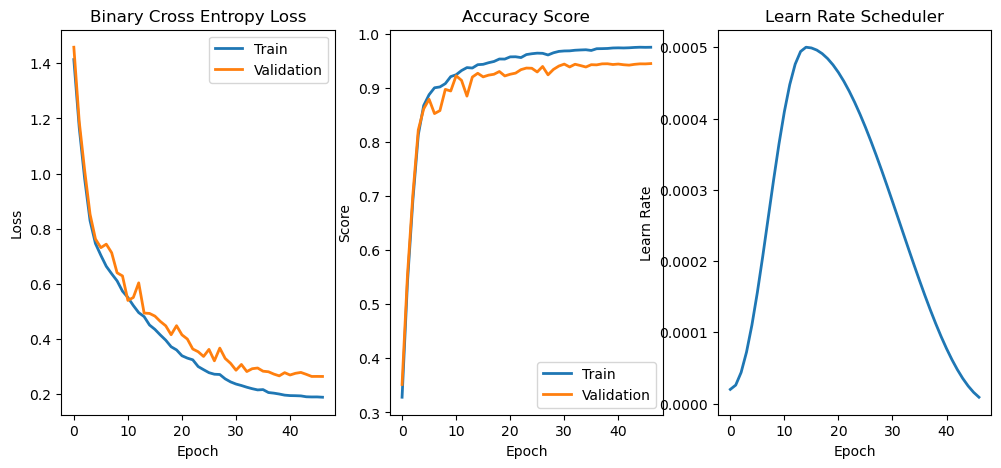

In [16]:
myTrain.plotTrainResults()

## loss on test

In [17]:
test_score = myTrain.evaluate_test_data(testData = dlTest ,score_fn=hS)

Test Score: 0.9548645601557533


## test case examine

Unique values in the raw output: [-2.689087  -2.6168785 -2.5742352 ... 13.104273  13.135772  13.629536 ]
Unique values in the predicted segmentation: [0 1 2 3]


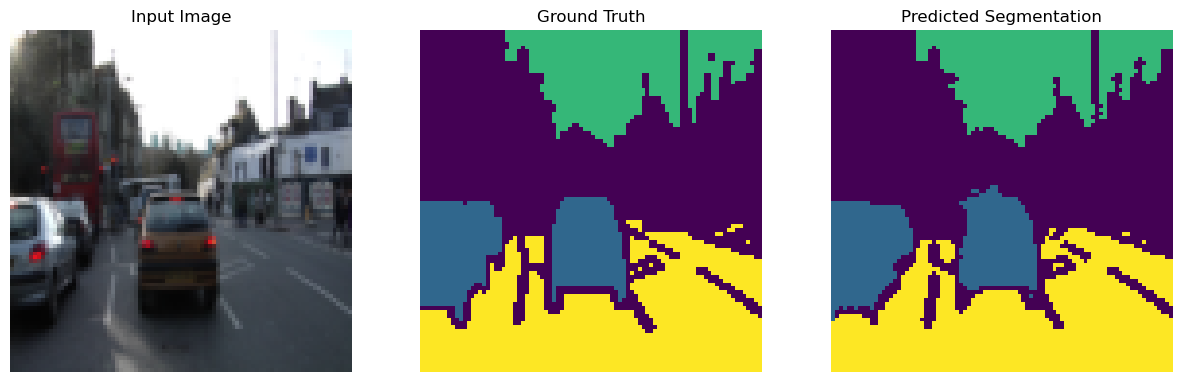

In [18]:


def visualize_prediction(model, dataset, index):
    model.eval()
    image, label = dataset[index]
    image = image.unsqueeze(0)  

    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).cpu().squeeze(0)  # Remove batch dimension and move to CPU

    # Debugging: Check unique values in the output and prediction
    print("Unique values in the raw output:", np.unique(output.cpu().numpy()))
    print("Unique values in the predicted segmentation:", np.unique(pred.numpy()))

    # Convert the tensors to images for visualization
    image = image.cpu().squeeze(0).permute(1, 2, 0)  # Convert from (C, H, W) to (H, W, C)
    label = label.cpu()
    pred = pred.cpu()

    # Plot the images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title('Input Image')
    ax[0].axis('off')

    ax[1].imshow(label)
    ax[1].set_title('Ground Truth')
    ax[1].axis('off')

    ax[2].imshow(pred)
    ax[2].set_title('Predicted Segmentation')
    ax[2].axis('off')

    plt.show()

# Visualize prediction on a sample image from the validation set
visualize_prediction(myTrain.model, val_dataset, index=1)

## new test

orig image.size = (960, 720)
image.size = (960, 720)


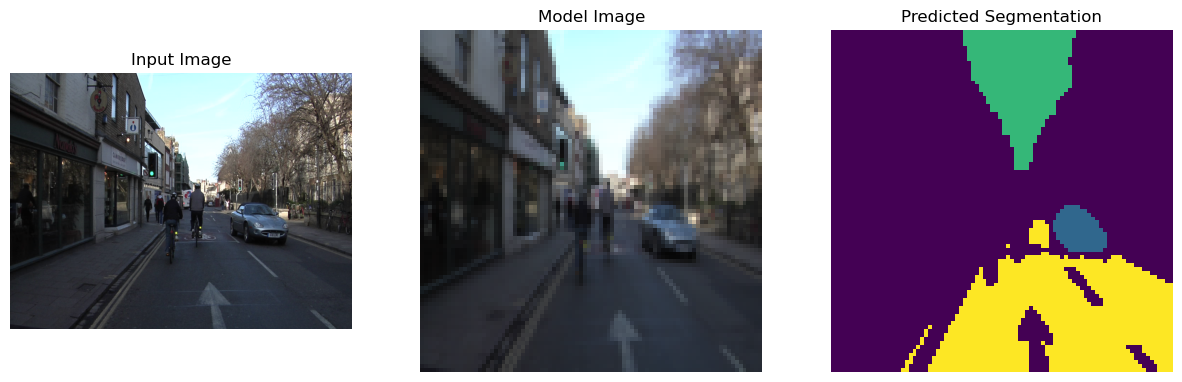

In [19]:
from PIL import Image, ImageOps

def visualize_new_prediction(model,new_image_path):
    if not os.path.exists(new_image_path):
        return None
    model.eval()
    image = Image.open(new_image_path).convert('RGB')
    
    ## make the same size as the training image
    print(f"orig image.size = {image.size}")
    test_size = (960, 720)
    image = ImageOps.fit(image, test_size, method=Image.LANCZOS)
    print(f"image.size = {image.size}")
    


    
    image_tensor = image_transform(image).unsqueeze(0)

    with torch.no_grad():
        output = model(image_tensor)
        pred = torch.argmax(output, dim=1).cpu().squeeze(0)  # Remove batch dimension and move to CPU
    
    # Convert the tensor image to numpy for visualization
    image_model = image_tensor.cpu().squeeze(0).permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)

    # Plot the images
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image)
    ax[0].set_title('Input Image')
    ax[0].axis('off')
    
    ax[1].imshow(image_model)
    ax[1].set_title('Model Image')
    ax[1].axis('off')

    ax[2].imshow(pred)
    ax[2].set_title('Predicted Segmentation')
    ax[2].axis('off')

    plt.show()

visualize_new_prediction(myTrain.model,'/home/vlad/Data/myTestImg/carPark1.jpeg')    
visualize_new_prediction(myTrain.model,'/data/tinyai/maxCNN/ai8x-training/data/CamVid/test/0016E5_08025.png')    
visualize_new_prediction(myTrain.model,'/data/solai/projB/1_unteSmall/results/carPark1.jpeg')    
visualize_new_prediction(myTrain.model,'/data/solai/projB/1_unteSmall/results/newTest1.jpg')    

# report

In [20]:
print(f"trainning   : EPOCHS_TO_RUN={EPOCHS_TO_RUN} ; batch={BATCH_SIZE}")
print(f"model       : file={MODEL_PATH}")
print(f"input data  : train_len =  {len(dlTrain.dataset)} ; test_len={len(dlVal.dataset)} ; val_len={len(dlTest.dataset)} ")
print(f"img data    : IMAGE_SIZE={IMAGE_SIZE}")
print(f"model       : NUM_CLASS={NUM_CLASS} ; NUM_CHANN={NUM_CHANN} ; FOLD_RATIO={FOLD_RATIO}")
print(f"score       : val_score={myTrain.lValScore[-1]} ; val_loss {myTrain.lValLoss[-1]}")
print(f"            : test_score={test_score}")
print(f"Trainable parameters: {myTrain.parma_stat()['trainable_params']}")
print(f"parameters_size_in_megabytes : {myTrain.parma_stat()['total_size_in_megabytes']}")

trainning   : EPOCHS_TO_RUN=50 ; batch=8
model       : file=./unet_model_large_x88_c3_e50_F1.pt
input data  : train_len =  100 ; test_len=100 ; val_len=100 
img data    : IMAGE_SIZE=(88, 88)
model       : NUM_CLASS=4 ; NUM_CHANN=3 ; FOLD_RATIO=1
score       : val_score=0.9455318021516101 ; val_loss 0.26375798521370725
            : test_score=0.9548645601557533
Trainable parameters: 273816
parameters_size_in_megabytes : 1.044525146484375
